# Modelo Preditivo de Redes Neurais LSTM 
Modelo preditivo de redes neurais Long Short 
Term Memory (LSTM) para predizer o valor de fechamento da bolsa de valores 
da ação BBAS3.SA

## Preparação dos Dados

### Coleta e Pré-processamento

In [1]:
import yfinance as yf
import pandas as pd

In [2]:
symbol = 'BBAS3.SA'
# ITUB3.SA
start_date = '2000-01-01'
end_date = '2024-10-01'
# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)



[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BBAS3.SA,BBAS3.SA,BBAS3.SA,BBAS3.SA,BBAS3.SA,BBAS3.SA
Date,,,,,,
2000-01-03 00:00:00+00:00,0.482337,1.366666,1.426666,1.366666,1.400000,1029600
2000-01-04 00:00:00+00:00,0.459396,1.301666,1.370000,1.301666,1.366666,628200
2000-01-05 00:00:00+00:00,0.464103,1.315000,1.316666,1.253333,1.300000,957600
2000-01-06 00:00:00+00:00,0.470572,1.333333,1.333333,1.300000,1.315000,410400
2000-01-07 00:00:00+00:00,0.459985,1.303333,1.333333,1.303333,1.333333,788400


### Dataset

In [ ]:
# 1. Resetar o índice para que 'Date' seja uma coluna em vez de índice
df.reset_index(inplace=True)

# 2. Ajustar o MultiIndex das colunas para transformar o 'Ticker' em uma coluna separada
df.columns = ['Date'] + [col[0] for col in df.columns[1:]]

# 3. Adicionar a coluna 'Ticker' com o valor correspondente para cada linha
df['Ticker'] = symbol    

# 4. Selecionar apenas as colunas necessárias
df = df[['Date', 'Open', 'High', 'Low', 'Volume', 'Close']]

In [6]:
df.head()

,Date,Open,High,Low,Volume,Close
0,2000-01-03 00:00:00+00:00,1.400000,1.426666,1.366666,1029600,1.366666
1,2000-01-04 00:00:00+00:00,1.366666,1.370000,1.301666,628200,1.301666
2,2000-01-05 00:00:00+00:00,1.300000,1.316666,1.253333,957600,1.315000
3,2000-01-06 00:00:00+00:00,1.315000,1.333333,1.300000,410400,1.333333
4,2000-01-07 00:00:00+00:00,1.333333,1.333333,1.303333,788400,1.303333


In [7]:
df.describe()

,Open,High,Low,Volume,Close
count,6216.000000,6216.000000,6216.000000,6.216000e+03,6216.000000
mean,12.082114,12.258665,11.897644,1.574273e+07,12.076977
std,7.087606,7.158477,7.008201,2.621998e+07,7.083882
min,0.916666,0.916666,0.885000,0.000000e+00,0.916666
25%,6.850000,6.998333,6.712500,4.269600e+06,6.847500
50%,12.502500,12.730000,12.297500,1.061230e+07,12.517500
75%,15.866250,16.075001,15.605000,1.925510e+07,15.900000
max,29.785000,29.955000,29.530001,6.408889e+08,29.799999


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6216 entries, 0 to 6215
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    6216 non-null   datetime64[ns, UTC]
 1   Open    6216 non-null   float64            
 2   High    6216 non-null   float64            
 3   Low     6216 non-null   float64            
 4   Volume  6216 non-null   int64              
 5   Close   6216 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 291.5 KB


In [9]:
# Verificar valores nulos
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Volume    0
Close     0
dtype: int64

In [10]:
# Verificando duplicatas
df.duplicated().sum()

0

### Normalização

In [11]:
features = df[['Open', 'High', 'Low', 'Volume', 'Close']]


Adj Close: Muitas vezes é uma versão ajustada do fechamento, redundante quando Close já está presente.
Date: Não agrega valor preditivo direto, mas é importante para interpretação e análise posterior (não para o modelo em si).

In [12]:
features

,Open,High,Low,Volume,Close
0,1.400000,1.426666,1.366666,1029600,1.366666
1,1.366666,1.370000,1.301666,628200,1.301666
2,1.300000,1.316666,1.253333,957600,1.315000
3,1.315000,1.333333,1.300000,410400,1.333333
4,1.333333,1.333333,1.303333,788400,1.303333
...,...,...,...,...,...
6211,27.700001,27.920000,27.370001,15235800,27.379999
6212,27.500000,27.559999,27.209999,13854100,27.299999
6213,27.450001,27.660000,27.280001,13119200,27.480000
6214,27.480000,27.620001,27.200001,14855700,27.250000


In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

print(scaled_data.shape)  # Verificando o shape do array escalado


(6216, 5)


In [14]:
import joblib

# Salvando o scaler para uso futuro ao utilizar o modelo
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

### Criando Sequência Temporal

In [ ]:
import numpy as np

def create_sequences(data, seq_length=60, forecast_horizons=[1, 3, 7, 15]):
    X, y = [], []
    for i in range(seq_length, len(data) - max(forecast_horizons)):
        X.append(data[i-seq_length:i])  # Janela de sequência
        y.append([data[i + h, -1] for h in forecast_horizons])  # Valores 'Close' nos horizontes desejados
    return np.array(X), np.array(y)


seq_length = 60 

# Criando sequências com múltiplos horizontes
X, y = create_sequences(scaled_data, seq_length)
print(f"Formato de X: {X.shape}, Formato de y: {y.shape}") 


Formato de X: (6141, 60, 5), Formato de y: (6141, 4)


### Treino e teste

In [16]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")


X_train: (4912, 60, 5), X_test: (1229, 60, 5)


In [17]:
forecast_horizons=[1, 3, 7, 15]

## Modelos

In [18]:
# Métrica de Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error


def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # em porcentagem
    return mse, rmse, mae, mape

In [19]:
df_metrics = pd.DataFrame(columns=['Modelo', 'Horizonte', 'MSE', 'RMSE', 'MAE', 'MAPE'])

### Modelo LSTM

#### Modelo

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

# Camadas LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada de saída com múltiplas previsões
model.add(Dense(units=len(forecast_horizons)))  # Saída para 1, 3, 7 e 15 dias

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 31,604
Trainable params: 31,604
Non-trainable params: 0
_________________________________________________________________


#### Treinamento

In [21]:
# Treinando o Modelo

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
154/154 [==============================] - 7s 15ms/step - loss: 0.0072 - val_loss: 0.0030
Epoch 2/20
154/154 [==============================] - 2s 12ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 3/20
154/154 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/20
154/154 [==============================] - 2s 11ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/20
154/154 [==============================] - 2s 11ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 6/20
154/154 [==============================] - 2s 12ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/20
154/154 [==============================] - 2s 11ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 8/20
154/154 [==============================] - 2s 11ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 9/20
154/154 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 10/20
154/154 [==============================] - 2s 12ms/step - loss: 0.0015 - val_lo

#### Predição do Modelo

In [22]:
# Definindo os horizontes de previsão
forecast_horizons = [1, 3, 7, 15]

# Inicializando uma matriz para armazenar previsões para cada horizonte
y_pred = np.zeros((X_test.shape[0], len(forecast_horizons)))

# Fazendo previsões para cada horizonte
for i, horizon in enumerate(forecast_horizons):
    X_test_horizon = X_test.copy()
    
    # Fazendo a previsão
    y_pred_scaled = model.predict(X_test_horizon)
    
    # Invertendo a normalização para as previsões
    predictions = np.zeros((y_pred_scaled.shape[0], features.shape[1]))  # 5 colunas
    predictions[:, -1] = y_pred_scaled[:, 0]  # Previsão para o fechamento

    # Invertendo a normalização
    y_pred[:, i] = scaler.inverse_transform(predictions)[:, -1]

# Invertendo a normalização para os valores reais
y_test_reshaped = np.zeros((y_test.shape[0], features.shape[1]))  # 5 colunas
y_test_reshaped[:, -1] = y_test[:, 0]  # Apenas a primeira coluna, correspondente ao 'Close'
y_test_inv = scaler.inverse_transform(y_test_reshaped)[:, -1]


39/39 [==============================] - 0s 4ms/step


#### Avaliando o Modelo

In [23]:
# Avaliar para cada horizonte
for i, horizon in enumerate(forecast_horizons):
    y_true_horizon = y_test[:, i]  # Valores reais para o horizonte atual
    y_pred_horizon = y_pred_scaled[:, i]  # Previsões para o horizonte atual

    # Calcular métricas
    mse, rmse, mae, mape = calculate_metrics(y_true_horizon, y_pred_horizon)

    # Exibir resultados
    print(f'Avaliação para Horizonte de {horizon} Dia(s):')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%\n')

    # Criar um novo dicionário com as métricas e o horizonte
    metrics_dict = {
        'Modelo': 'modelo_simples',
        'Horizonte': horizon,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Adicionar as métricas ao DataFrame existente
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

df_metrics


Avaliação para Horizonte de 1 Dia(s):
MSE: 0.0009
RMSE: 0.0301
MAE: 0.0236
MAPE: 3.62%

Avaliação para Horizonte de 3 Dia(s):
MSE: 0.0012
RMSE: 0.0350
MAE: 0.0262
MAPE: 4.09%

Avaliação para Horizonte de 7 Dia(s):
MSE: 0.0023
RMSE: 0.0483
MAE: 0.0362
MAPE: 5.59%

Avaliação para Horizonte de 15 Dia(s):
MSE: 0.0045
RMSE: 0.0674
MAE: 0.0504
MAPE: 7.80%



C:\Users\pablo\AppData\Local\Temp\ipykernel_9424\3182421312.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)


,Modelo,Horizonte,MSE,RMSE,MAE,MAPE
0,modelo_simples,1,0.000908,0.030127,0.023617,3.616441
1,modelo_simples,3,0.001228,0.035040,0.026200,4.092343
2,modelo_simples,7,0.002334,0.048314,0.036194,5.588341
3,modelo_simples,15,0.004542,0.067397,0.050414,7.803700


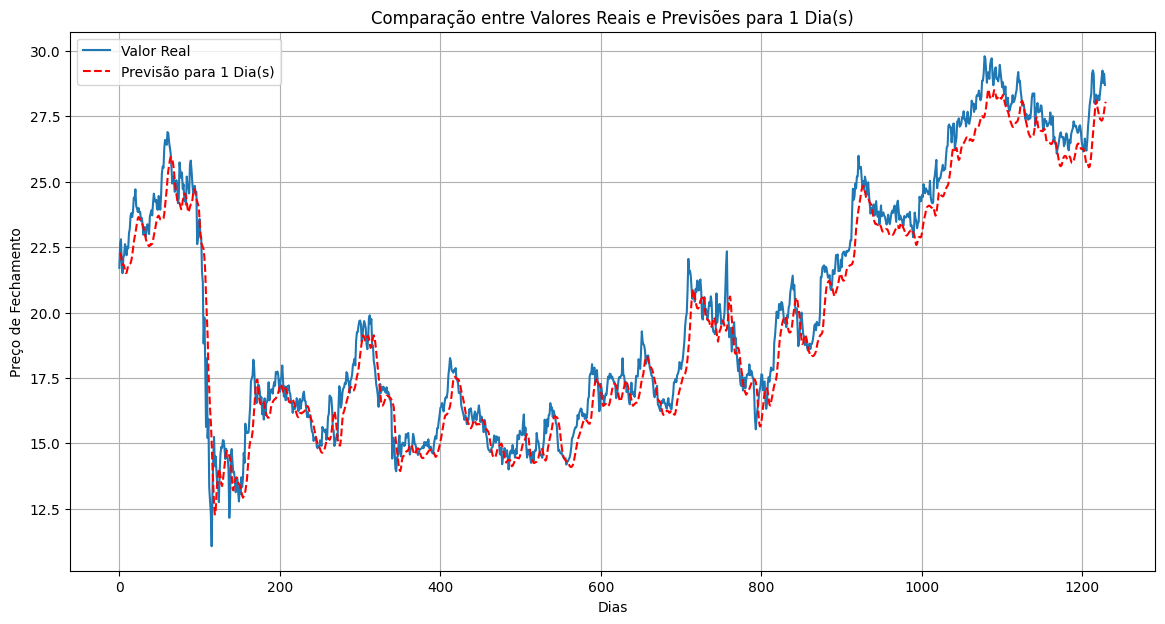

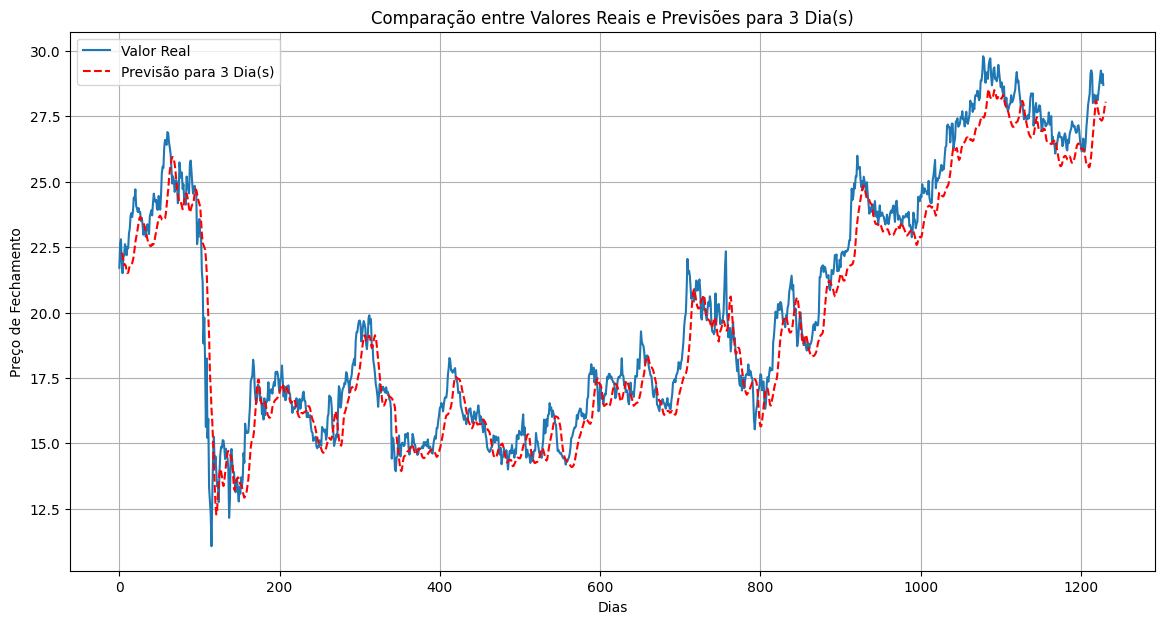

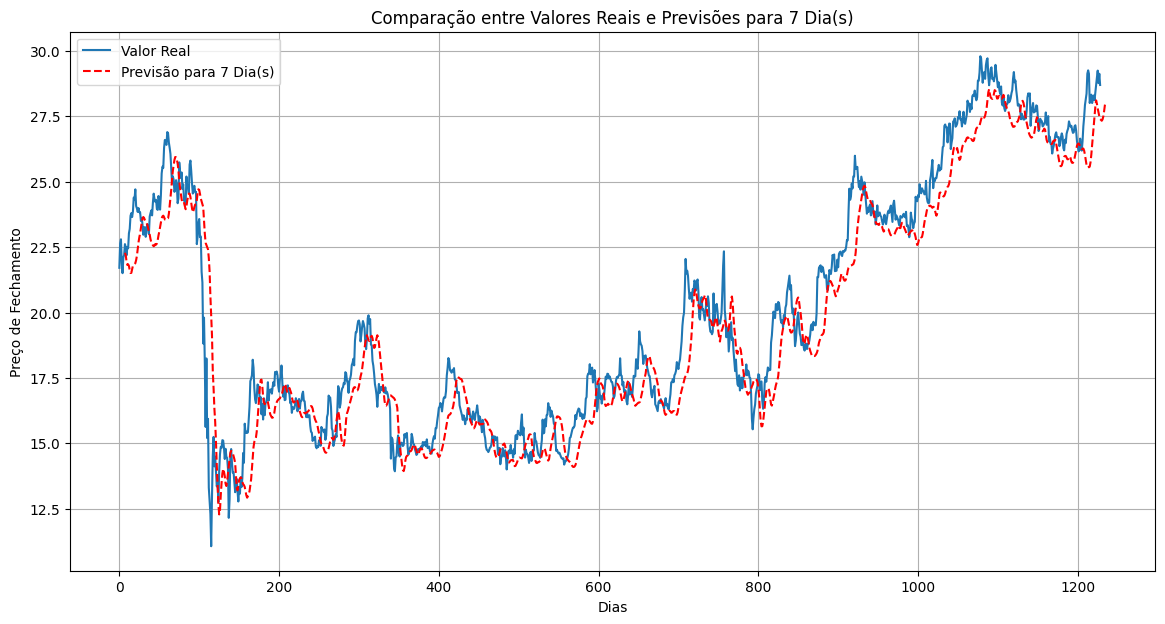

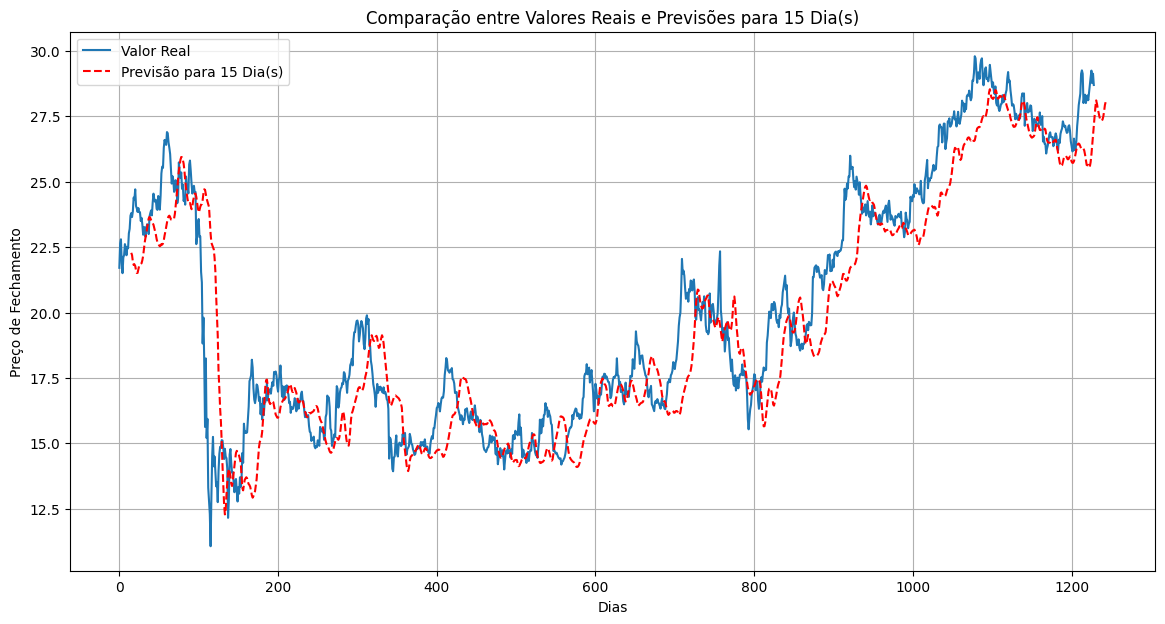

In [24]:
import matplotlib.pyplot as plt

# Criar um gráfico separado para cada horizonte de previsão
for i, horizon in enumerate(forecast_horizons):
    plt.figure(figsize=(14, 7))
    
    # Eixo X ajustado para o horizonte
    x_horizon = np.arange(horizon, len(y_test_inv) + horizon)  # Ajusta para o horizonte de previsão

    # Plotar os valores reais
    plt.plot(y_test_inv, label='Valor Real')

    # Plotar as previsões para o horizonte atual
    plt.plot(x_horizon, y_pred[:, i], color = 'red', label=f'Previsão para {horizon} Dia(s)', linestyle='--')

    # Personalizar o gráfico
    plt.title(f'Comparação entre Valores Reais e Previsões para {horizon} Dia(s)')
    plt.xlabel('Dias')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.grid()
    plt.show()


In [25]:
# Salvando o modelo em formato HDF5
model.save('modelo_simples.h5')
print("Modelo salvo como 'modelo_simples.h5'")

Modelo salvo como 'modelo_simples.h5'


### Modelo LSTM com Hiperparâmetros

In [26]:
# Placa de vídeo

import tensorflow as tf

print("Versão do TensorFlow:", tf.__version__)

# Verifique se há GPUs disponíveis
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Versão do TensorFlow: 2.9.3
Num GPUs Available:  1


### Teste 1

In [27]:
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Definição do conjunto de horizontes de previsão
forecast_horizons = [1, 3, 7, 15]

def build_model(hp):
    model = Sequential()
    
    # Número de camadas LSTM
    num_layers = hp.Int('num_layers', 1, 4)
    
    for i in range(num_layers):
        # Adicionando camadas LSTM
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            return_sequences=(i < num_layers - 1),  # Sequencial se não for última camada
            kernel_regularizer=regularizers.l2(1e-4)  # Regularização leve para evitar overfitting
        ))
        
        # Dropout para evitar overfitting
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.2, 0.5, step=0.1)))

    # Camada de saída
    model.add(Dense(units=len(forecast_horizons)))  # Saída para 1, 3, 7 e 15 dias

    # Escolher otimizador com base na escolha do usuário
    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'], default='adam')
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compilação do modelo
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']  # Adicionando MAE como métrica adicional
    )
    
    return model

# Configuração do Keras Tuner para busca de hiperparâmetros
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,  # Aumentar para maior exploração
    executions_per_trial=3,
    directory='models',
    project_name='teste1'
)

# Definindo o batch_size
batch_size = 32

# EarlyStopping para interromper se não houver melhoria
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Realizar a busca por hiperparâmetros com conjunto de validação separado
tuner.search(
    X_train, y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=batch_size, 
    callbacks=[early_stop]
)

# Recuperando o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]




Trial 30 Complete [00h 02m 15s]
val_loss: 0.008141415504117807

Best val_loss So Far: 0.0021264998552699885
Total elapsed time: 01h 19m 54s


In [28]:
# Avaliação do modelo com o conjunto de teste
y_pred = best_model.predict(X_test)

# Inverter a normalização para previsões e valores reais
y_pred_reshaped = np.zeros((y_pred.shape[0], X_test.shape[2]))
y_pred_reshaped[:, -1] = y_pred[:, 0]
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)[:, -1]

y_test_reshaped = np.zeros((y_test.shape[0], X_test.shape[2]))
y_test_reshaped[:, -1] = y_test[:, 0]
y_test_inv = scaler.inverse_transform(y_test_reshaped)[:, -1]



39/39 [==============================] - 1s 4ms/step


In [29]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Avaliação do modelo em cada horizonte de previsão
for i, horizon in enumerate(forecast_horizons):
    mse, rmse, mae, mape = calculate_metrics(y_test[:, i], y_pred[:, i])
    print(f'Avaliação para Horizonte de {horizon} Dia(s):')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%\n')

    # Criar um novo dicionário com as métricas e o horizonte
    metrics_dict = {
        'Modelo': 'modelo_teste1',
        'Horizonte': horizon,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Adicionar as métricas ao DataFrame existente
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

df_metrics

Avaliação para Horizonte de 1 Dia(s):
MSE: 0.0010
RMSE: 0.0311
MAE: 0.0240
MAPE: 4.06%

Avaliação para Horizonte de 3 Dia(s):
MSE: 0.0012
RMSE: 0.0349
MAE: 0.0259
MAPE: 4.18%

Avaliação para Horizonte de 7 Dia(s):
MSE: 0.0022
RMSE: 0.0471
MAE: 0.0349
MAPE: 5.52%

Avaliação para Horizonte de 15 Dia(s):
MSE: 0.0040
RMSE: 0.0629
MAE: 0.0455
MAPE: 7.54%



,Modelo,Horizonte,MSE,RMSE,MAE,MAPE
0,modelo_simples,1,0.000908,0.030127,0.023617,3.616441
1,modelo_simples,3,0.001228,0.035040,0.026200,4.092343
2,modelo_simples,7,0.002334,0.048314,0.036194,5.588341
3,modelo_simples,15,0.004542,0.067397,0.050414,7.803700
4,modelo_teste1,1,0.000968,0.031108,0.023957,4.064248
5,modelo_teste1,3,0.001216,0.034873,0.025927,4.179717
6,modelo_teste1,7,0.002218,0.047099,0.034931,5.518891
7,modelo_teste1,15,0.003954,0.062878,0.045506,7.539848


In [30]:
# Salvando o modelo em formato HDF5
best_model.save('modelo_teste1.h5')
print("Modelo salvo como 'modelo_teste1.h5'")

Modelo salvo como 'modelo_teste1.h5'


### Teste 2

##### Modelo

In [31]:
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()
    
    # Número de camadas LSTM
    num_layers = hp.Int('num_layers', 1, 4)
    
    for i in range(num_layers):
        # Camadas de LSTM
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            return_sequences=(i < num_layers - 1),
            kernel_regularizer=regularizers.l2(hp.Float('l2_reg', 1e-4, 1e-2, sampling='LOG'))
        ))
        
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.2, 0.5, step=0.1)))
        model.add(BatchNormalization())  # Adicionar Batch Normalization após cada camada LSTM

    # Camada de saída com múltiplas previsões
    model.add(Dense(units=len(forecast_horizons)))  # Saída para 1, 3, 7 e 15 dias

    # Compilação do modelo
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
        loss='mean_squared_error'
    )
    
    return model

# Configuração do Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,  # Número de tentativas para melhor exploração
    executions_per_trial=3,
    directory='models',
    project_name='teste2'
)

# Defina o batch_size como hiperparâmetro
batch_size = 32 

# Configuração do EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitorar a perda de validação
    patience=7,          # Esperar até 7 épocas sem melhoria
    restore_best_weights=True  # Restaurar os melhores pesos após o treinamento
)

# Realizar a busca por hiperparâmetros com EarlyStopping
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=batch_size, callbacks=[early_stop])

best_model = tuner.get_best_models(num_models=1)[0]


Trial 30 Complete [00h 02m 04s]
val_loss: 0.0027916434531410537

Best val_loss So Far: 0.0018006707541644573
Total elapsed time: 02h 10m 14s


#### Previsão

In [32]:
y_pred_scaled = best_model.predict(X_test)

39/39 [==============================] - 1s 3ms/step


#### Avaliação

In [33]:
# 2. Invertendo a normalização para as previsões
# Crie uma matriz de zeros com a forma correta
predictions = np.zeros((y_pred_scaled.shape[0], features.shape[1]))  # Assumindo que features é o DataFrame original

# Atribuindo as previsões à coluna de fechamento para cada horizonte
for i in range(len(forecast_horizons)):
    predictions[:, -1] = y_pred_scaled[:, i]  # Apenas a previsão para o horizonte i

# Invertendo a normalização
y_pred_inv = scaler.inverse_transform(predictions)[:, -1]

# 3. Invertendo a normalização para os valores reais
y_test_reshaped = np.zeros((y_test.shape[0], features.shape[1]))  # 5 colunas
y_test_reshaped[:, -1] = y_test[:, 0]  # Apenas a primeira coluna, correspondente ao 'Close'

y_test_inv = scaler.inverse_transform(y_test_reshaped)[:, -1]

# 4. Avaliar para cada horizonte
for i, horizon in enumerate(forecast_horizons):
    y_true_horizon = y_test[:, i]  # Valores reais para o horizonte atual
    y_pred_horizon = y_pred_scaled[:, i]  # Previsões para o horizonte atual

    # Inverter a normalização para as previsões para o horizonte atual
    predictions_horizon = np.zeros((y_pred_horizon.shape[0], features.shape[1]))
    predictions_horizon[:, -1] = y_pred_horizon
    y_pred_horizon_inv = scaler.inverse_transform(predictions_horizon)[:, -1]

    # Inverter a normalização para os valores reais para o horizonte atual
    y_test_horizon_reshaped = np.zeros((y_test.shape[0], features.shape[1]))
    y_test_horizon_reshaped[:, -1] = y_test[:, i]
    y_test_horizon_inv = scaler.inverse_transform(y_test_horizon_reshaped)[:, -1]

    # Calcular métricas
    mse, rmse, mae, mape = calculate_metrics(y_test_horizon_inv, y_pred_horizon_inv)

    # Exibir resultados
    print(f'Avaliação para Horizonte de {horizon} Dia(s):')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%\n')

    # Criar um novo dicionário com as métricas e o horizonte
    metrics_dict = {
        'Modelo': 'modelo_teste2',
        'Horizonte': horizon,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Adicionar as métricas ao DataFrame existente
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

df_metrics

Avaliação para Horizonte de 1 Dia(s):
MSE: 0.4493
RMSE: 0.6703
MAE: 0.4857
MAPE: 2.58%

Avaliação para Horizonte de 3 Dia(s):
MSE: 0.9023
RMSE: 0.9499
MAE: 0.6866
MAPE: 3.77%

Avaliação para Horizonte de 7 Dia(s):
MSE: 1.7412
RMSE: 1.3195
MAE: 0.9616
MAPE: 4.94%

Avaliação para Horizonte de 15 Dia(s):
MSE: 3.0294
RMSE: 1.7405
MAE: 1.2112
MAPE: 6.64%



,Modelo,Horizonte,MSE,RMSE,MAE,MAPE
0,modelo_simples,1,0.000908,0.030127,0.023617,3.616441
1,modelo_simples,3,0.001228,0.035040,0.026200,4.092343
2,modelo_simples,7,0.002334,0.048314,0.036194,5.588341
3,modelo_simples,15,0.004542,0.067397,0.050414,7.803700
4,modelo_teste1,1,0.000968,0.031108,0.023957,4.064248
5,modelo_teste1,3,0.001216,0.034873,0.025927,4.179717
6,modelo_teste1,7,0.002218,0.047099,0.034931,5.518891
7,modelo_teste1,15,0.003954,0.062878,0.045506,7.539848
8,modelo_teste2,1,0.449310,0.670306,0.485720,2.580350
9,modelo_teste2,3,0.902267,0.949877,0.686626,3.774867


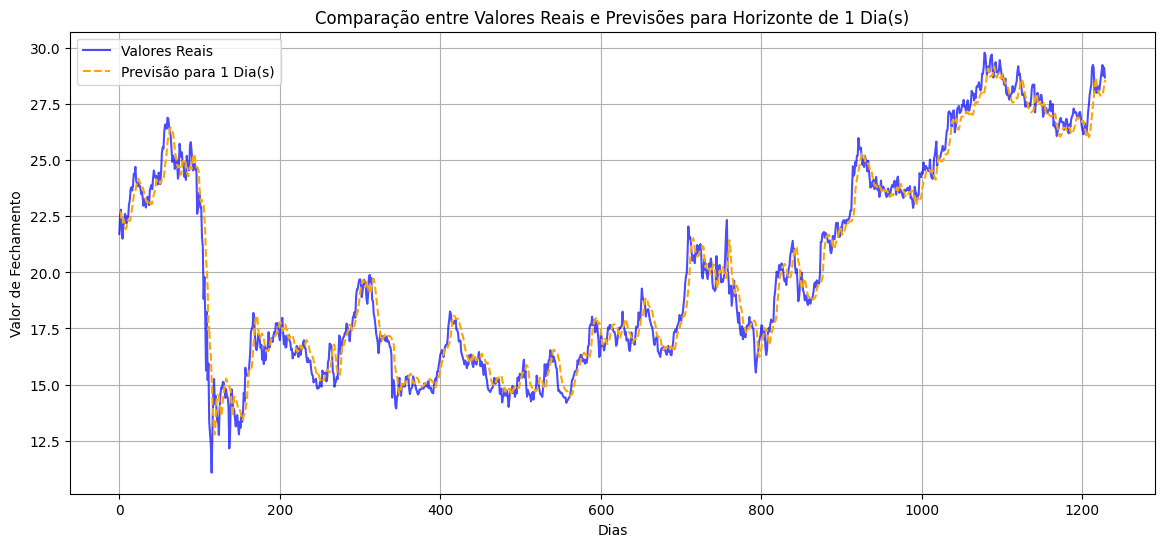

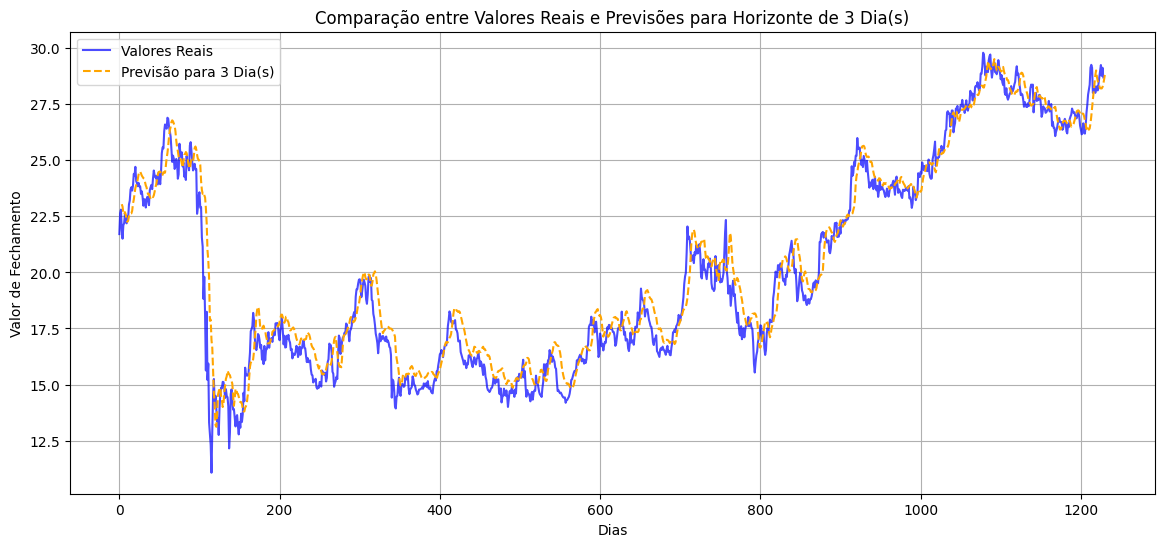

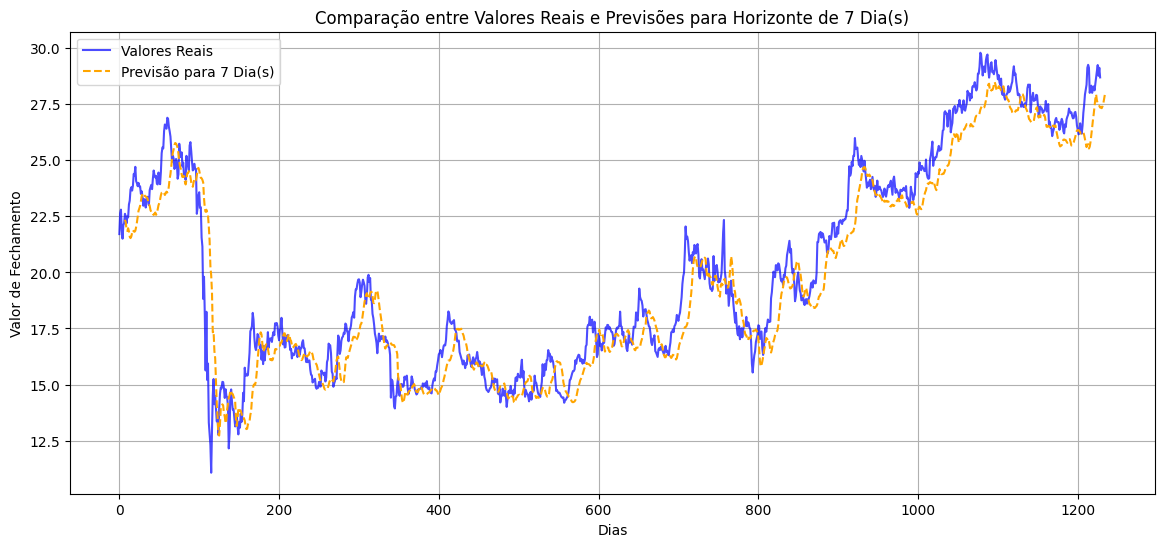

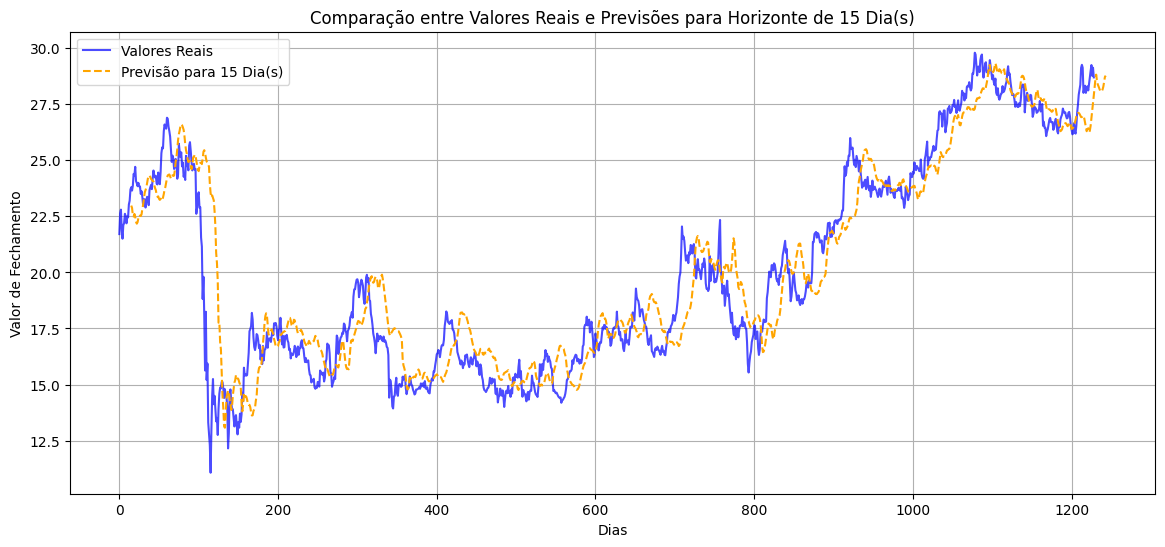

In [34]:
# Visualizando Predições

import matplotlib.pyplot as plt

for i, horizon in enumerate(forecast_horizons):
    plt.figure(figsize=(14, 6))
    
    # Plotar valores reais
    plt.plot(y_test_inv, label='Valores Reais', color='blue', alpha=0.7)

    # Previsões para o horizonte atual
    y_pred_horizon = y_pred_scaled[:, i]
    
    # Inverter a normalização para as previsões do horizonte atual
    predictions_horizon = np.zeros((y_pred_horizon.shape[0], features.shape[1]))
    predictions_horizon[:, -1] = y_pred_horizon
    y_pred_horizon_inv = scaler.inverse_transform(predictions_horizon)[:, -1]

    # Ajustar o eixo X para cada horizonte
    x_horizon = np.arange(horizon, len(y_test_inv) + horizon)

    # Plotar previsões
    plt.plot(x_horizon, y_pred_horizon_inv, label=f'Previsão para {horizon} Dia(s)', linestyle='--', color='orange')

    # Personalizar o gráfico
    plt.title(f'Comparação entre Valores Reais e Previsões para Horizonte de {horizon} Dia(s)')
    plt.xlabel('Dias')
    plt.ylabel('Valor de Fechamento')
    plt.legend()
    plt.grid()
    plt.show()


#### Salvando o Modelo

In [35]:
# Salvando o modelo em formato HDF5
best_model.save('modelo_teste2.h5')
print("Modelo salvo como 'modelo_teste2.h5'")

Modelo salvo como 'modelo_teste2.h5'


### Teste 3

In [36]:
from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import numpy as np

# Definição do conjunto de horizontes de previsão (1, 3, 7, e 15 dias)
forecast_horizons = [1, 3, 7, 15]

# Função para construir o modelo LSTM com hiperparâmetros
def build_model(hp):
    model = Sequential()

    # Definindo o número de camadas LSTM
    num_layers = hp.Int('num_layers', 1, 4)  
    for i in range(num_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', 32, 256, step=32),
            return_sequences=(i < num_layers - 1),
            activation='tanh',  
            recurrent_activation='sigmoid', 
            recurrent_dropout=0.0, 
            kernel_regularizer=l2(hp.Float('l2_reg', 0.0, 0.01, step=0.001))
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.2, 0.5, step=0.1)))

    # Camada densa intermediária
    dense_units = hp.Int('dense_units', 32, 128, step=16)
    model.add(Dense(units=dense_units, activation=hp.Choice('dense_activation', ['relu', 'tanh'])))

    # Camada de saída para múltiplas previsões
    model.add(Dense(units=len(forecast_horizons), activation='linear'))

    # Otimizador Adam
    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG'))
    
    # Compilação do modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    # Testei com loss huber, mas a perfomance foi muito ruim

    return model

# Configuração do Keras Tuner para busca de hiperparâmetros
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=2,
    directory='models',
    project_name='teste3'
)

batch_size = 32

# EarlyStopping para interrupção antecipada
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Scheduler para ajustar a taxa de aprendizado
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Executa a busca de hiperparâmetros
tuner.search(
    X_train, y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=batch_size, 
    callbacks=[early_stop, lr_scheduler]
)

# Recupera o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]



Trial 186 Complete [00h 00m 26s]
val_loss: 0.003889769781380892

Best val_loss So Far: 0.002168355043977499
Total elapsed time: 00h 47m 39s


In [37]:
# Avaliação do modelo com o conjunto de teste
y_pred = best_model.predict(X_test)

# Inverter a normalização para previsões e valores reais
y_pred_reshaped = np.zeros((y_pred.shape[0], X_test.shape[2]))
y_pred_reshaped[:, -1] = y_pred[:, 0]
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)[:, -1]

y_test_reshaped = np.zeros((y_test.shape[0], X_test.shape[2]))
y_test_reshaped[:, -1] = y_test[:, 0]
y_test_inv = scaler.inverse_transform(y_test_reshaped)[:, -1]



39/39 [==============================] - 1s 3ms/step


In [38]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Avaliação do modelo em cada horizonte de previsão
for i, horizon in enumerate(forecast_horizons):
    mse, rmse, mae, mape = calculate_metrics(y_test[:, i], y_pred[:, i])
    print(f'Avaliação para Horizonte de {horizon} Dia(s):')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%\n')

    # Criar um novo dicionário com as métricas e o horizonte
    metrics_dict = {
        'Modelo': 'modelo_teste3',
        'Horizonte': horizon,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Adicionar as métricas ao DataFrame existente
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

df_metrics


Avaliação para Horizonte de 1 Dia(s):
MSE: 0.0010
RMSE: 0.0316
MAE: 0.0245
MAPE: 3.57%

Avaliação para Horizonte de 3 Dia(s):
MSE: 0.0013
RMSE: 0.0363
MAE: 0.0278
MAPE: 4.19%

Avaliação para Horizonte de 7 Dia(s):
MSE: 0.0024
RMSE: 0.0489
MAE: 0.0373
MAPE: 5.60%

Avaliação para Horizonte de 15 Dia(s):
MSE: 0.0068
RMSE: 0.0822
MAE: 0.0658
MAPE: 9.45%



,Modelo,Horizonte,MSE,RMSE,MAE,MAPE
0,modelo_simples,1,0.000908,0.030127,0.023617,3.616441
1,modelo_simples,3,0.001228,0.035040,0.026200,4.092343
2,modelo_simples,7,0.002334,0.048314,0.036194,5.588341
3,modelo_simples,15,0.004542,0.067397,0.050414,7.803700
4,modelo_teste1,1,0.000968,0.031108,0.023957,4.064248
5,modelo_teste1,3,0.001216,0.034873,0.025927,4.179717
6,modelo_teste1,7,0.002218,0.047099,0.034931,5.518891
7,modelo_teste1,15,0.003954,0.062878,0.045506,7.539848
8,modelo_teste2,1,0.449310,0.670306,0.485720,2.580350
9,modelo_teste2,3,0.902267,0.949877,0.686626,3.774867


In [39]:
# Salvando o modelo em formato HDF5
best_model.save('modelo_teste3.h5')
print("Modelo salvo como 'modelo_teste3.h5'")

Modelo salvo como 'modelo_teste3.h5'


### Teste 4

In [40]:
from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import numpy as np

# Definição do conjunto de horizontes de previsão (1, 3, 7, e 15 dias)
forecast_horizons = [1, 3, 7, 15]

# Função para construir o modelo LSTM com hiperparâmetros
def build_model(hp):
    model = Sequential()

    # Definindo o número de camadas LSTM
    num_layers = hp.Int('num_layers', 1, 4)  
    for i in range(num_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', 32, 256, step=32),
            return_sequences=(i < num_layers - 1),  # Definir corretamente o return_sequences
            activation='tanh',  # Usar a ativação 'tanh' para cuDNN
            recurrent_activation='sigmoid',  # Usar a ativação 'sigmoid'
            kernel_regularizer=l2(hp.Float('l2_reg', 0.0, 0.01, step=0.001))
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.2, 0.5, step=0.1)))

    # Camada de saída para múltiplas previsões
    model.add(Dense(units=len(forecast_horizons), activation='linear'))  

    # Otimizador Adam
    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG'))
    
    # Compilação do modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Configuração do Keras Tuner para busca de hiperparâmetros
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=2,
    directory='models',
    project_name='teste4'
)

batch_size = 32

# EarlyStopping para interrupção antecipada
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Scheduler para ajustar a taxa de aprendizado
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Executa a busca de hiperparâmetros
tuner.search(
    X_train, y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=batch_size, 
    callbacks=[early_stop, lr_scheduler]
)

# Recupera o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 186 Complete [00h 00m 17s]
val_loss: 0.0025949475821107626

Best val_loss So Far: 0.001897378358989954
Total elapsed time: 00h 42m 30s


In [41]:
# Avaliação do modelo com o conjunto de teste
y_pred = best_model.predict(X_test)

# Inverter a normalização para previsões e valores reais
y_pred_reshaped = np.zeros((y_pred.shape[0], X_test.shape[2]))
y_pred_reshaped[:, -1] = y_pred[:, 0]
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)[:, -1]

y_test_reshaped = np.zeros((y_test.shape[0], X_test.shape[2]))
y_test_reshaped[:, -1] = y_test[:, 0]
y_test_inv = scaler.inverse_transform(y_test_reshaped)[:, -1]



39/39 [==============================] - 1s 3ms/step


In [42]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Avaliação do modelo em cada horizonte de previsão
for i, horizon in enumerate(forecast_horizons):
    mse, rmse, mae, mape = calculate_metrics(y_test[:, i], y_pred[:, i])
    print(f'Avaliação para Horizonte de {horizon} Dia(s):')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%\n')

    # Criar um novo dicionário com as métricas e o horizonte
    metrics_dict = {
        'Modelo': 'modelo_teste4',
        'Horizonte': horizon,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Adicionar as métricas ao DataFrame existente
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

df_metrics

Avaliação para Horizonte de 1 Dia(s):
MSE: 0.0008
RMSE: 0.0286
MAE: 0.0208
MAPE: 3.38%

Avaliação para Horizonte de 3 Dia(s):
MSE: 0.0012
RMSE: 0.0353
MAE: 0.0259
MAPE: 4.20%

Avaliação para Horizonte de 7 Dia(s):
MSE: 0.0027
RMSE: 0.0516
MAE: 0.0391
MAPE: 5.93%

Avaliação para Horizonte de 15 Dia(s):
MSE: 0.0042
RMSE: 0.0651
MAE: 0.0490
MAPE: 7.73%



,Modelo,Horizonte,MSE,RMSE,MAE,MAPE
0,modelo_simples,1,0.000908,0.030127,0.023617,3.616441
1,modelo_simples,3,0.001228,0.035040,0.026200,4.092343
2,modelo_simples,7,0.002334,0.048314,0.036194,5.588341
3,modelo_simples,15,0.004542,0.067397,0.050414,7.803700
4,modelo_teste1,1,0.000968,0.031108,0.023957,4.064248
5,modelo_teste1,3,0.001216,0.034873,0.025927,4.179717
6,modelo_teste1,7,0.002218,0.047099,0.034931,5.518891
7,modelo_teste1,15,0.003954,0.062878,0.045506,7.539848
8,modelo_teste2,1,0.449310,0.670306,0.485720,2.580350
9,modelo_teste2,3,0.902267,0.949877,0.686626,3.774867


In [43]:
# Salvando o modelo em formato HDF5
best_model.save('modelo_teste4.h5')
print("Modelo salvo como 'modelo_teste4.h5'")

Modelo salvo como 'modelo_teste4.h5'


### Teste 5

In [44]:
from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import numpy as np

# Definição do conjunto de horizontes de previsão (1, 3, 7, e 15 dias)
forecast_horizons = [1, 3, 7, 15]

# Função para construir o modelo LSTM com hiperparâmetros
def build_model(hp):
    model = Sequential()

    # Definindo o número de camadas LSTM
    num_layers = hp.Int('num_layers', 1, 4)  
    for i in range(num_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', 32, 256, step=32),
            return_sequences=(i < num_layers - 1),
            activation=hp.Choice('lstm_activation', ['tanh', 'relu']),  # Função de ativação ajustável
            recurrent_activation='sigmoid',  
            kernel_regularizer=l2(hp.Float('l2_reg', 0.0, 0.01, step=0.001))
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.2, 0.5, step=0.1)))

    # Removida a camada densa intermediária
    # Camada de saída para múltiplas previsões
    model.add(Dense(units=len(forecast_horizons), activation='linear'))  # Camada de saída sem camada densa intermediária

    # Otimizador Adam
    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG'))
    
    # Compilação do modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Configuração do Keras Tuner para busca de hiperparâmetros
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=2,
    directory='models',
    project_name='teste5'  # Renomeado para um novo projeto
)

batch_size = 32

# EarlyStopping para interrupção antecipada
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Scheduler para ajustar a taxa de aprendizado
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Executa a busca de hiperparâmetros
tuner.search(
    X_train, y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=batch_size, 
    callbacks=[early_stop, lr_scheduler]
)

# Recupera o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 186 Complete [00h 05m 46s]
val_loss: 0.00910708587616682

Best val_loss So Far: 0.002052885014563799
Total elapsed time: 04h 33m 11s


In [45]:
# Avaliação do modelo com o conjunto de teste
y_pred = best_model.predict(X_test)

# Inverter a normalização para previsões e valores reais
y_pred_reshaped = np.zeros((y_pred.shape[0], X_test.shape[2]))
y_pred_reshaped[:, -1] = y_pred[:, 0]
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)[:, -1]

y_test_reshaped = np.zeros((y_test.shape[0], X_test.shape[2]))
y_test_reshaped[:, -1] = y_test[:, 0]
y_test_inv = scaler.inverse_transform(y_test_reshaped)[:, -1]



39/39 [==============================] - 1s 4ms/step


In [46]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Avaliação do modelo em cada horizonte de previsão
for i, horizon in enumerate(forecast_horizons):
    mse, rmse, mae, mape = calculate_metrics(y_test[:, i], y_pred[:, i])
    print(f'Avaliação para Horizonte de {horizon} Dia(s):')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%\n')

    # Criar um novo dicionário com as métricas e o horizonte
    metrics_dict = {
        'Modelo': 'modelo_teste5',
        'Horizonte': horizon,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Adicionar as métricas ao DataFrame existente
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

df_metrics

Avaliação para Horizonte de 1 Dia(s):
MSE: 0.0012
RMSE: 0.0341
MAE: 0.0266
MAPE: 3.89%

Avaliação para Horizonte de 3 Dia(s):
MSE: 0.0013
RMSE: 0.0366
MAE: 0.0274
MAPE: 4.20%

Avaliação para Horizonte de 7 Dia(s):
MSE: 0.0029
RMSE: 0.0542
MAE: 0.0417
MAPE: 6.17%

Avaliação para Horizonte de 15 Dia(s):
MSE: 0.0053
RMSE: 0.0726
MAE: 0.0563
MAPE: 8.39%



,Modelo,Horizonte,MSE,RMSE,MAE,MAPE
0,modelo_simples,1,0.000908,0.030127,0.023617,3.616441
1,modelo_simples,3,0.001228,0.035040,0.026200,4.092343
2,modelo_simples,7,0.002334,0.048314,0.036194,5.588341
3,modelo_simples,15,0.004542,0.067397,0.050414,7.803700
4,modelo_teste1,1,0.000968,0.031108,0.023957,4.064248
5,modelo_teste1,3,0.001216,0.034873,0.025927,4.179717
6,modelo_teste1,7,0.002218,0.047099,0.034931,5.518891
7,modelo_teste1,15,0.003954,0.062878,0.045506,7.539848
8,modelo_teste2,1,0.449310,0.670306,0.485720,2.580350
9,modelo_teste2,3,0.902267,0.949877,0.686626,3.774867


In [47]:
# Salvando o modelo em formato HDF5
best_model.save('modelo_teste5.h5')
print("Modelo salvo como 'modelo_teste5.h5'")

Modelo salvo como 'modelo_teste5.h5'


### O modelo_teste4 foi escolhido devido ao seu desempenho consistente em todos os horizontes avaliados (1, 3, 7 e 15 dias). Ele apresentou os menores erros absolutos (MSE, RMSE e MAE), garantindo previsões mais próximas dos valores reais. Além disso, mostrou robustez mesmo em horizontes mais longos, mantendo boa precisão e generalização. Essa consistência torna o modelo ideal para implementação na API, atendendo aos requisitos de confiabilidade e eficiência.